In [1]:
!pip install -qqq pip
!pip install -qqq torch
!pip install -qqq transformers
!pip install -qqq datasets
!pip install -qqq accelerate
!pip install -qqq bitsandbytes
!pip install -qqq peft
!pip install -qqq trl
!pip install -qqq colored==2.2.4
!pip install -qqq nltk
!pip install -qqq rouge

### **Setup**

In [2]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftConfig
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    DataCollatorForLanguageModeling
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize
from rouge import rouge

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set( style = "whitegrid", palette = "muted", font_scale = 1.2 )
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "text.color": "white",
    "axes.linewidth": 0.5,
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth":  0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update( MY_STYLE )

SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [11]:
!git clone https://github.com/khangdzox/COS30018-Mitigate-Hallucination.git

Cloning into 'COS30018-Mitigate-Hallucination'...
Updating files:   7% (214/2969)
Updating files:   8% (238/2969)
Updating files:   9% (268/2969)
Updating files:  10% (297/2969)
Updating files:  11% (327/2969)
Updating files:  12% (357/2969)
Updating files:  13% (386/2969)
Updating files:  14% (416/2969)
Updating files:  14% (422/2969)
Updating files:  15% (446/2969)
Updating files:  16% (476/2969)
Updating files:  17% (505/2969)
Updating files:  17% (522/2969)
Updating files:  18% (535/2969)
Updating files:  19% (565/2969)
Updating files:  20% (594/2969)
Updating files:  20% (599/2969)
Updating files:  21% (624/2969)
Updating files:  22% (654/2969)
Updating files:  23% (683/2969)
Updating files:  23% (686/2969)
Updating files:  24% (713/2969)
Updating files:  25% (743/2969)
Updating files:  25% (764/2969)
Updating files:  26% (772/2969)
Updating files:  27% (802/2969)
Updating files:  28% (832/2969)
Updating files:  28% (849/2969)
Updating files:  29% (862/2969)
Updating files:  30% (

In [4]:
seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "COS30018-Mitigate-Hallucination/Finetuning/QLoRA/4"
NEW_MODEL = "Llama-3-8B-Project"

In [6]:
import os
os.environ["HUGGINGFACE_HUB_TOKEN"] = ""

### **Quantisation and Tokenisation**

In [8]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
base_model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", quantization_config=quantization_config, token=os.environ["HUGGINGFACE_HUB_TOKEN"])

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
# model = PeftModel.from_pretrained(base_model, TMODEL_NAME, device_map = "cuda", torch_dtype = torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, token=os.environ["HUGGINGFACE_HUB_TOKEN"])
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=quantization_config,
    token=os.environ["HUGGINGFACE_HUB_TOKEN"]
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Embedding(128264, 4096)

### **Data Preprocessing**

In [10]:
dataset=load_dataset("PatronusAI/HaluBench")

In [13]:
dataset["test"][:2]

{'id': ['d3fb4c3c-d21b-480a-baa0-98d6d0d17c1d',
  '8603663e-c53b-46db-a482-a867f12ff3b4'],
 'passage': ['Hoping to rebound from the road loss to the Chargers, the Rams went home for Week 9, as they fought the Kansas City Chiefs in a "Show Me State Showdown". The Chiefs struck first as RB Larry Johnson got a 1-yard TD run for the only score of the period.  In the second quarter, things got worse for the Rams as QB Damon Huard completed a 3-yard TD pass to TE Tony Gonzalez, while kicker Lawrence Tynes nailed a 42-yard field goal.  St. Louis got on the board with RB Steven Jackson getting a 2-yard TD run, yet Huard and Gonzalez hooked up with each other again on a 25-yard TD strike.  Rams kicker Jeff Wilkins made a 41-yard field goal to end the half.  In the third quarter, QB Marc Bulger completed a 2-yard TD pass to WR Kevin Curtis for the only score of the period, yet the only score of the fourth quarter came from Huard completing an 11-yard TD pass to TE Kris Wilson. With the loss, the

In [14]:
rows = []
for i in dataset["test"]:
    if isinstance(i["answer"], list):
        correct_answers = "; ".join(i["answer"])
    else:
        correct_answers = str(i["answer"])

    rows.append(
        {
            "question": i["question"],
            "context": i['passage'],
            "correct_answers": correct_answers,
            "label": i["label"]
        }
    )

df = pd.DataFrame(rows)

In [15]:
df.head()

,question,context,correct_answers,label
0,Which team scored the longest field goal kick ...,Hoping to rebound from the road loss to the Ch...,"['Rams', 'second', 'Marc Bulger', 'Kevin Curtis']",FAIL
1,How many percent were not Irish?,"As of the census of 2000, there were 218,590 p...",87.1,FAIL
2,How many yards was the second longest field go...,Hoping to rebound from the road loss to the Ch...,42,FAIL
3,How long was the last touchdown?,Hoping to rebound from their tough overtime ro...,18-yard,FAIL
4,How many in percent from the census weren't Ir...,"As of the census of 2000, there were 218,590 p...",87.1,FAIL


In [16]:
print(df.isnull().value_counts())
fail_count = df['label'].value_counts().get('FAIL', 0)

print(f"Number of 'FAIL' occurrences: {fail_count}")

question  context  correct_answers  label
False     False    False            False    14900
Name: count, dtype: int64
Number of 'FAIL' occurrences: 7170


In [18]:
def format_example(row: dict):
    prompt = dedent(
        f"""
        ### Instruction:
        {row["context"]}

        ### Input:
        {row["question"]}

        ### Response:
        {row["correct_answers"]}

        ### Evaluation:
        """
    )
    messages = (
        {
            "role": "system",
            "content": "Read the passage and evaluate if the provided answer is correct. Respond with 'PASS' if the answer is correct and 'FAIL' if the answer is incorrect.",
        },
        {
            "role": "user",
            "content": prompt,
        },
    )
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [19]:
df["text"] = df.apply(format_example, axis=1)

In [20]:
def count_tokens(row: dict)->int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
            )["input_ids"]
        )

In [21]:
df["token_count"] = df.apply(count_tokens, axis=1)

In [22]:
df.head()

,question,context,correct_answers,label,text,token_count
0,Which team scored the longest field goal kick ...,Hoping to rebound from the road loss to the Ch...,"['Rams', 'second', 'Marc Bulger', 'Kevin Curtis']",FAIL,<|begin_of_text|><|start_header_id|>system<|en...,309
1,How many percent were not Irish?,"As of the census of 2000, there were 218,590 p...",87.1,FAIL,<|begin_of_text|><|start_header_id|>system<|en...,304
2,How many yards was the second longest field go...,Hoping to rebound from the road loss to the Ch...,42,FAIL,<|begin_of_text|><|start_header_id|>system<|en...,297
3,How long was the last touchdown?,Hoping to rebound from their tough overtime ro...,18-yard,FAIL,<|begin_of_text|><|start_header_id|>system<|en...,303
4,How many in percent from the census weren't Ir...,"As of the census of 2000, there were 218,590 p...",87.1,FAIL,<|begin_of_text|><|start_header_id|>system<|en...,307


In [23]:
print(df.text.iloc[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the passage and evaluate if the provided answer is correct. Respond with 'PASS' if the answer is correct and 'FAIL' if the answer is incorrect.<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
Hoping to rebound from the road loss to the Chargers, the Rams went home for Week 9, as they fought the Kansas City Chiefs in a "Show Me State Showdown". The Chiefs struck first as RB Larry Johnson got a 1-yard TD run for the only score of the period.  In the second quarter, things got worse for the Rams as QB Damon Huard completed a 3-yard TD pass to TE Tony Gonzalez, while kicker Lawrence Tynes nailed a 42-yard field goal.  St. Louis got on the board with RB Steven Jackson getting a 2-yard TD run, yet Huard and Gonzalez hooked up with each other again on a 25-yard TD strike.  Rams kicker Jeff Wilkins made a 41-yard field goal to end the half.  In the third quarter, QB Marc Bulger completed a 2-yard TD pass to W

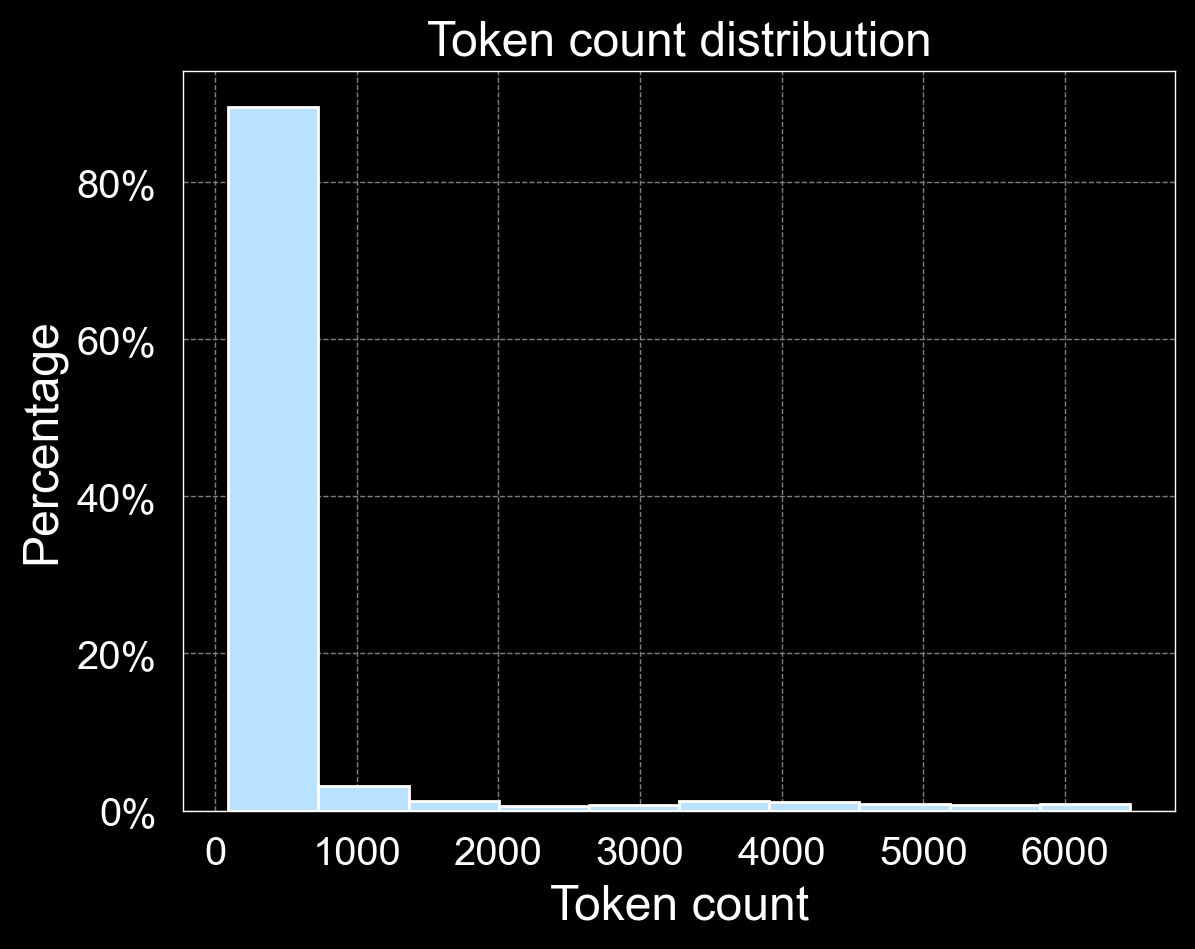

In [24]:
plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Token count")
plt.ylabel("Percentage")
plt.title("Token count distribution")
plt.show()

In [25]:
upper_bound = 200
lower_bound = 10

In [26]:
len(df[(df.token_count < upper_bound) & (df.token_count > lower_bound)]), len(df), len(df[(df.token_count < upper_bound)  & (df.token_count > lower_bound)]) / len(df)

(7934, 14900, 0.5324832214765101)

In [27]:
total_num = 3000

In [28]:
df = df[(df.token_count < upper_bound) & (df.token_count > lower_bound)]
df = df.sample(total_num)
df.shape

(3000, 6)

In [29]:
train, temp = train_test_split(df, test_size=0.5, random_state=SEED)
val, test = train_test_split(temp, test_size=0.5, random_state=SEED)

In [30]:
len(train) / len(df), len(val) / len(df), len(test) / len(df)

(0.5, 0.25, 0.25)

In [31]:
len(train), len(val), len(test)

(1500, 750, 750)

In [32]:
train_num = 1500
val_num = 450
test_num = 500

In [33]:
train.sample(n=train_num).to_json("train.json", orient="records", lines=True)
val.sample(n=val_num).to_json("val.json", orient="records", lines=True)
test.sample(n=test_num).to_json("test.json", orient="records", lines=True)

In [34]:
dataset = load_dataset(
    "json",
    data_files={
        "train": "train.json",
        "validation": "val.json",
        "test": "test.json"
        }
    )

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'correct_answers', 'label', 'text', 'token_count'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['question', 'context', 'correct_answers', 'label', 'text', 'token_count'],
        num_rows: 450
    })
    test: Dataset({
        features: ['question', 'context', 'correct_answers', 'label', 'text', 'token_count'],
        num_rows: 500
    })
})

In [36]:
print(dataset["test"][0]["text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the passage and evaluate if the provided answer is correct. Respond with 'PASS' if the answer is correct and 'FAIL' if the answer is incorrect.<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
 His works included an authoritative biography of General George S. Patton.General George Smith Patton Jr. (November 11, 1885 – December 21, 1945) was a senior officer of the United States Army who commanded the U.S. Seventh Army in the Mediterranean and European theaters of World War II, but is best known for his leadership of the U.S. Third Army in France and Germany following the Allied invasion of Normandy in June 1944.

### Input:
What is the birth date of the person Martin Blumenson wrote an authoritative biography of?

### Response:
November 11, 1885

### Evaluation:<|eot_id|>


### **Test Base Model**

In [37]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens = 128,
    return_full_text = False,
)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausal

In [38]:
def create_test_prompt(data_row):
    prompt = dedent(
        f"""
        ### Instruction:
        {data_row["context"]}

        ### Input:
        {data_row["question"]}

        ### Response:
        {data_row["correct_answers"]}

        ### Evaluation:
        """
    )
    messages = (
        {
            "role": "system",
            "content": "Read the context and evaluate if the provided answer is correct. Respond with 'PASS' if the answer is correct and 'FAIL' if the answer is incorrect.",
        },
        {
            "role": "user",
            "content": prompt,
        },
    )
    return tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False
    )

In [39]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the context and evaluate if the provided answer is correct. Respond with 'PASS' if the answer is correct and 'FAIL' if the answer is incorrect.<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
 His works included an authoritative biography of General George S. Patton.General George Smith Patton Jr. (November 11, 1885 – December 21, 1945) was a senior officer of the United States Army who commanded the U.S. Seventh Army in the Mediterranean and European theaters of World War II, but is best known for his leadership of the U.S. Third Army in France and Germany following the Allied invasion of Normandy in June 1944.

### Input:
What is the birth date of the person Martin Blumenson wrote an authoritative biography of?

### Response:
November 11, 1885

### Evaluation:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [40]:
%%time
output = pipe(prompt)
response = f"""
answer: {row["label"]}
prediction: {output[0]["generated_text"]}
"""
print(response)

c:\Users\pink\anaconda3\envs\LLama3-hallucinate\Lib\site-packages\transformers\models\llama\modeling_llama.py:660: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



answer: PASS
prediction: PASS

CPU times: total: 1min 35s
Wall time: 2min 44s


In [ ]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the context and evaluate if the provided answer is correct. Respond with 'PASS' if the answer is correct and 'FAIL' if the answer is incorrect.<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
 The team was in 2009 not an UCI Women's Teams anymore and consisted of a mix of mountain bikers and road racers (mainly men): Rob Hayles, Ed Clancy, Ian Wilkinson, Andy Tennant, Mark McNally, Rob Partridge, Seb Batchelor, David Fletcher, Annie Last, Sharon Laws, Ian Bibby.Sharon Laws (born 7 July 1974) is a British former professional cyclist, who currently works as an environmental consultant.

### Input:
What type of cyclists were teammates of a former professional cyclist born in 1974 who is currently an environmental consultant?

### Response:
mountain bikers and road racers

### Evaluation:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
%%time
output = pipe(prompt)
response = f"""
answer: {row["label"]}
prediction: {output[0]["generated_text"]}
"""
print(response)


answer: PASS
prediction: ### Evaluation:
The provided answer is correct.

CPU times: user 1.7 s, sys: 446 ms, total: 2.15 s
Wall time: 2.14 s


In [ ]:
row = dataset["test"][2]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the context and evaluate if the provided answer is correct. Respond with 'PASS' if the answer is correct and 'FAIL' if the answer is incorrect.<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
Park Dietz (born 1948) is a forensic psychiatrist who has consulted or testified in many of the highest profile US criminal cases including Joel Rifkin, Arthur Shawcross, Jeffrey Dahmer, The Unabomber, Richard Kuklinski, the Beltway sniper attacks, and Jared Lee Loughner. He was associated with members of the American Mafia, namely the DeCavalcante crime family of Newark, New Jersey, and the Five Families of New York City.

### Input:
What forensic psychiatrist consulted on numbers cases including one for a contract killer associated with the DeCavalcante crime family?

### Response:
Park Dietz was a psychologist.

### Evaluation:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
%%time
output = pipe(prompt)
response = f"""
answer: {row["label"]}
prediction: {output[0]["generated_text"]}
"""
print(response)


answer: FAIL
prediction: FAIL

The correct answer is Park Dietz was a forensic psychiatrist, not a psychologist.

CPU times: user 2.76 s, sys: 423 ms, total: 3.18 s
Wall time: 3.22 s


In [41]:
def calculate_accuracy(prediction, reference):
    pred_words = set(word_tokenize(prediction))
    ref_words = set(word_tokenize(reference))

    common_words = pred_words.intersection(ref_words)

    accuracy_pred = len(common_words) / len(pred_words) if pred_words else 0
    accuracy_ref = len(common_words) / len(ref_words) if ref_words else 0

    return accuracy_pred, accuracy_ref

In [42]:
from rouge import Rouge
import nltk
rows = []
rouge = Rouge()
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

for row in tqdm(dataset["test"]):
    prompt = create_test_prompt(row)
    output = pipe(prompt)
    prediction = output[0]["generated_text"]
    reference = row["label"]

    meteor = meteor_score([word_tokenize(reference)], word_tokenize(prediction), alpha=0.9, beta=3, gamma=0.5)

    bleu = sentence_bleu([word_tokenize(reference)], word_tokenize(prediction))

    rouge_scores = rouge.get_scores(prediction, reference, avg=True)

    accuracy_pred, accuracy_ref = calculate_accuracy(prediction, reference)

    rows.append(
        {
            "question": row["question"],
            "context": row["context"],
            "answer": reference,
            "prediction": prediction,
            "meteor_score": meteor,
            "bleu_score": bleu,
            "rouge_1": rouge_scores['rouge-1']['f'],
            "rouge_2": rouge_scores['rouge-2']['f'],
            "rouge_l": rouge_scores['rouge-l']['f'],
            "Accuracy_pred": accuracy_pred,
            "Accuracy_ref": accuracy_ref
        }
    )

predictions_df = pd.DataFrame(rows)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pink\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pink\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pink\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 500/500 [31:12<00:00,  3.74s/it] 


In [ ]:
predictions_df.to_csv('Q_base_model.csv', index=False)